# Whole brain data processing

In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import fish_proc.wholeBrainDask.cellProcessing_single_WS as fwc
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190907/fish00/7dpf_HuC-GC7FF_GU-fwd_fish00_exp01_20190907_172639/'
import dask.array as da

In [3]:
brain_map = np.load(save_root+'Y_ave.npy')

In [4]:
# dense
# _ = np.load(save_root+'cell_raw_dff.npz', allow_pickle=True)
# sparse
_ = np.load(save_root+'cell_raw_dff_sparse.npz', allow_pickle=True)
A = _['A']
F_ = _['F']
A_loc = _['A_loc']
_ = None

In [5]:
# first remove components with low signals
valid_cell = F_.max(axis=-1)>20

In [6]:
A = A[valid_cell]
A_loc = A_loc[valid_cell]
F_ = F_[valid_cell]

In [7]:
F_dask = da.from_array(F_, chunks=('auto', -1))

In [8]:
baseline_ = da.map_blocks(fwc.baseline, F_dask, dtype='float', window=1000, percentile=20, downsample=10).compute()
dFF = F_/baseline_ - 1

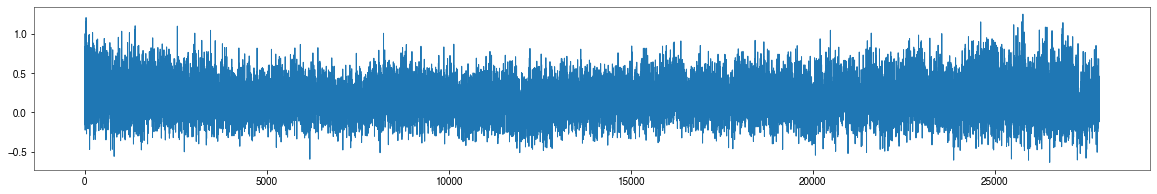

In [9]:
plt.figure(figsize=(20, 3))
plt.plot(dFF[0])

In [10]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(A):
    A_loc_ = A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.4).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

## plot whole brain segmentation

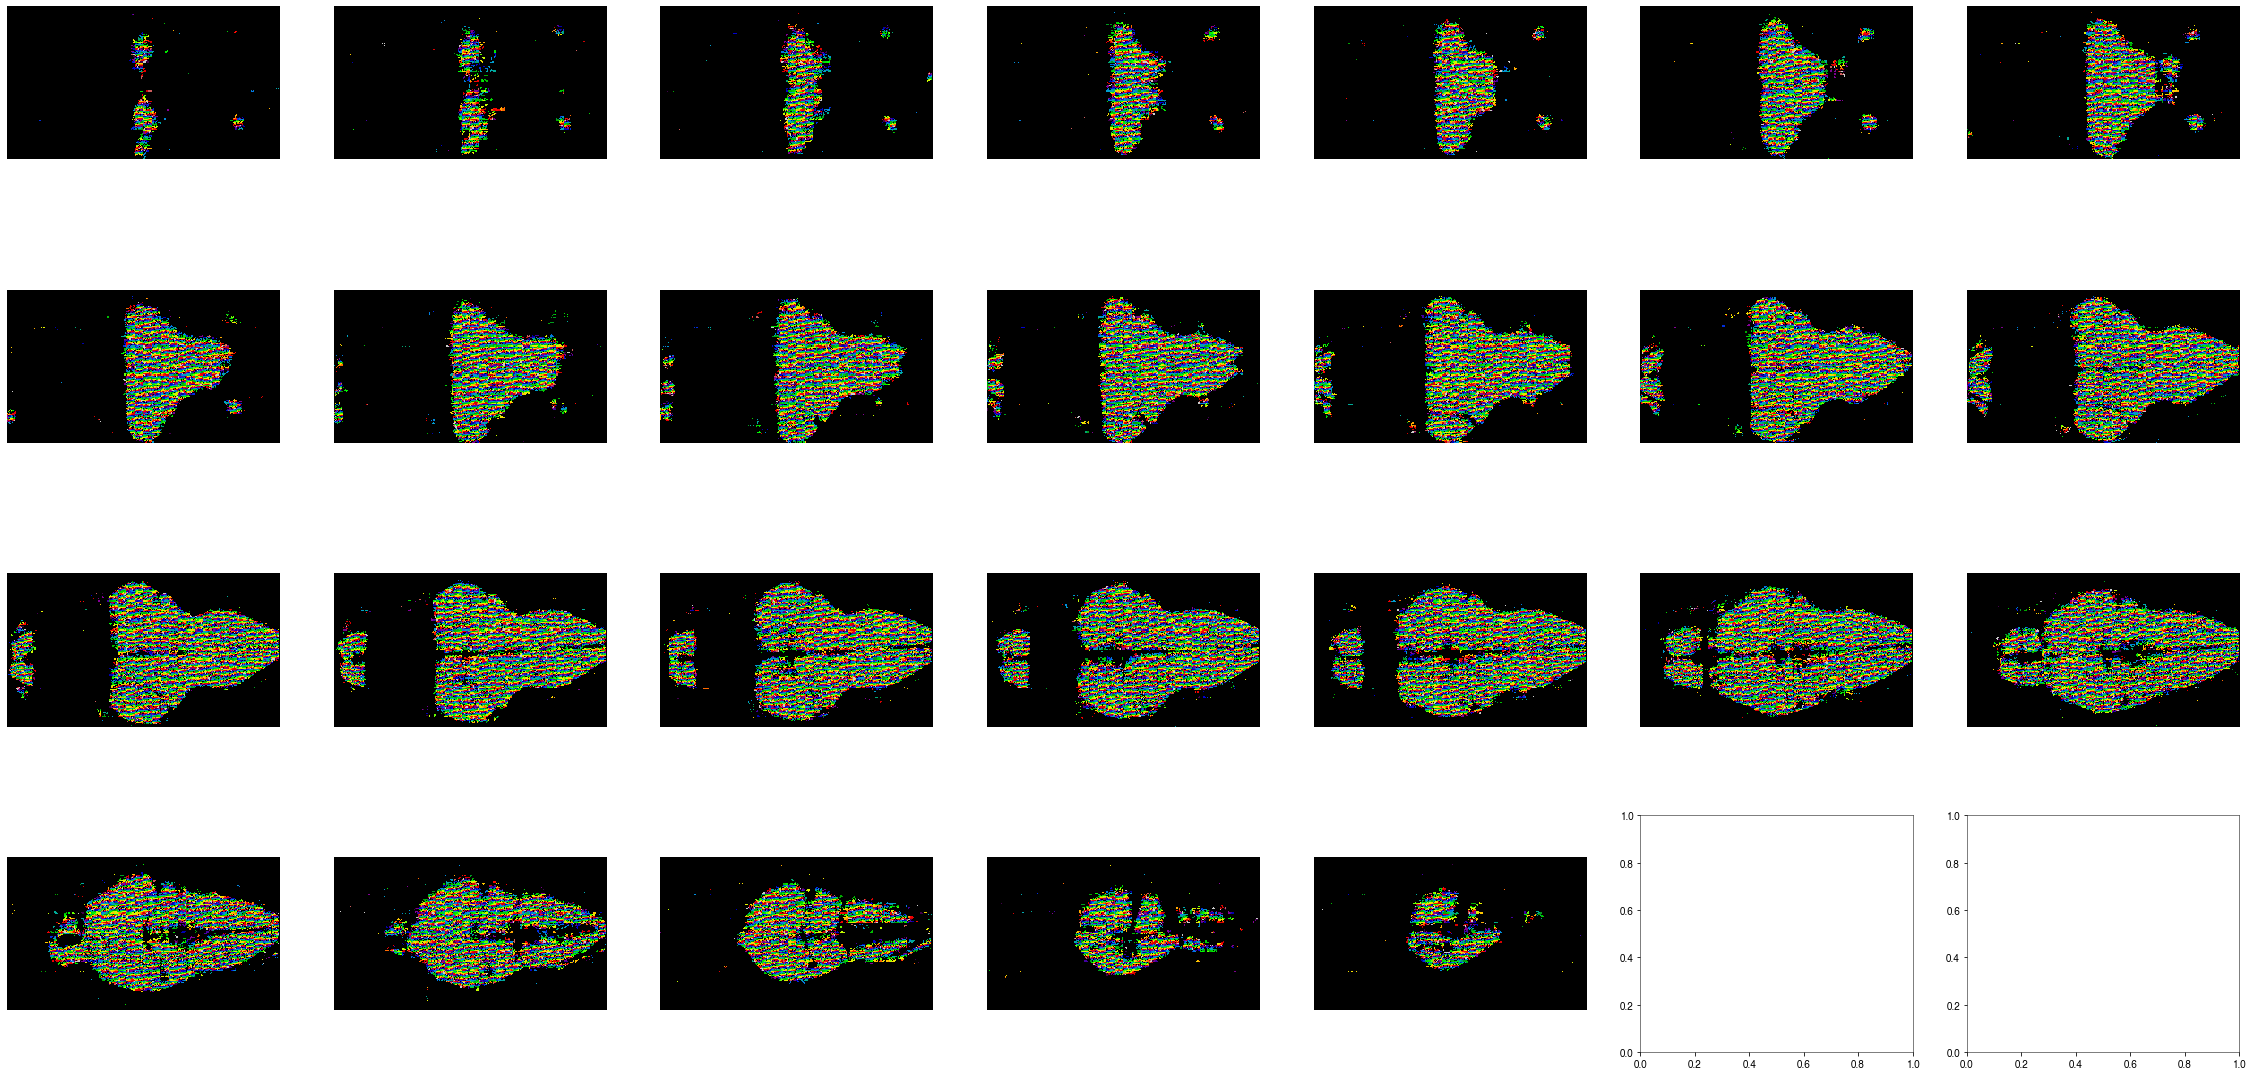

In [12]:
fig, ax = plt.subplots(4, A_ext.shape[0]//4+1, figsize=(40, 20))
ax = ax.flatten()
for n, _ in enumerate(A_ext):
    _[_>0] = _[_>0]%32+1
    ax[n].imshow(_, cmap=plt.cm.nipy_spectral)
    ax[n].axis('off')
plt.show()